<a href="https://colab.research.google.com/github/anderm18/CurlingVAR/blob/main/CurlingDataRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Retrieving images of Curling houses from Bonspiel video feed

The goal of this notebook is to produce a dataset which will then be reviewed and annotated of images of curling houses. A dataset like this (from my own research) does not exist, due to the variation in curling livestreams. Luckily,
my friends at Schenectady Curling Club livestream every hosted Bonspiel (a curling competition), which includes live feed from set cameras recording only the curling house. This makes parsing this data feasible, but still difficult. The goal is to try to pull out as many images as possible, having various stones in the house, as well as some empty house images. Depending on how well this turns out I might put it on kaggle, we'll see!


NOTE: This is being written on Google Colab, if you see weird google-like code, it is to adjust to the Colab runtime environment

### 1. Load in Bonspiel Video

These Bonspiel videos are huge, at the time of writing I have retrieved one 5 GB 8 hour bonspiel feed from the Achiles 2022 Saturday Morning Draw @ Schenectady Curling Club

Video Credit: Schenectady Curling Club\
[Website](https://schenectadycurlingclub.us/)\
[YouTube](https://www.youtube.com/@schenectadycurling2935)\
[Instagram](https://www.instagram.com/curlschenectady/?hl=en)\
[Facebook](https://www.facebook.com/curlschenectady/)\
[X/Twitter](https://twitter.com/curlschenectady?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor)


In [12]:
import cv2
import numpy as np
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt

In [2]:
# Mount Google Drive storage
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
bonspiel = cv2.VideoCapture('/content/drive/My Drive/CurlingVideos/achilles2022.mp4')

In [4]:
success, frame = bonspiel.read()
bonspiel.release()

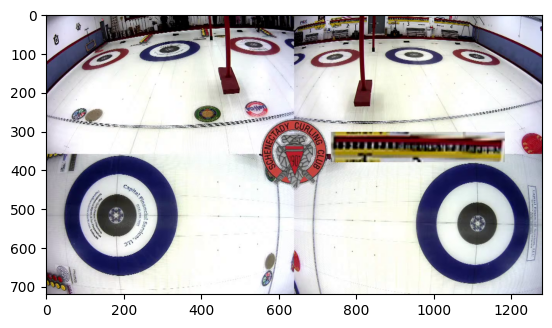

In [5]:
if success:
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  img = Image.fromarray(frame)

  plt.imshow(img)

So we know that this image will always look the same, every time. We can extract two useful images here: the bottom right and bottom left houses. Let's start trying to split the image. A lot of this is just tweaking to get the best house image desired:

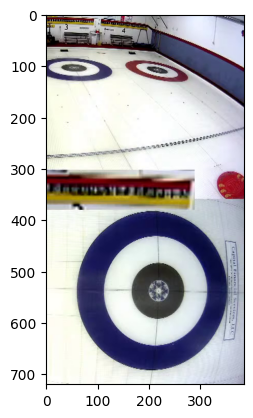

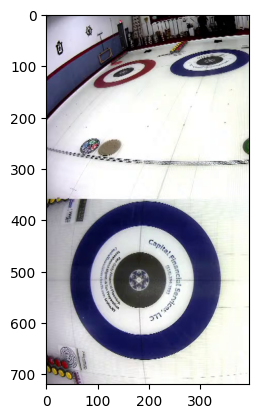

In [6]:
sliced_img_right = frame[:, frame.shape[0]+175:]
sliced_img_left = frame[:, :frame.shape[0]-325]
middle_split_right, middle_split_left = Image.fromarray(sliced_img_right), Image.fromarray(sliced_img_left)
plt.imshow(middle_split_right)
plt.show()
plt.imshow(middle_split_left)

Now, same idea just on the vertical:

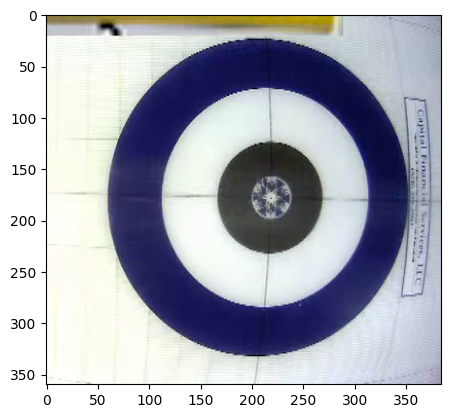

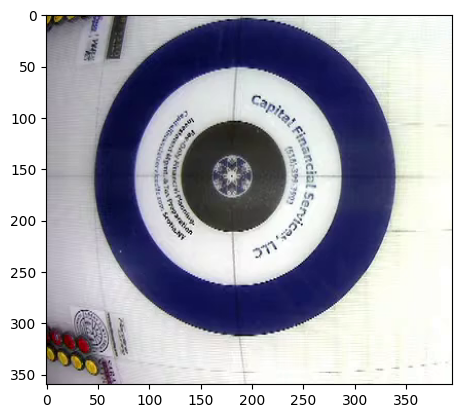

In [7]:
sliced_img_right = sliced_img_right[(frame.shape[1]//2)-280:, :]
sliced_img_left = sliced_img_left[(frame.shape[1]//2)-280:, :]
full_split_right, full_split_left = Image.fromarray(sliced_img_right), Image.fromarray(sliced_img_left)
plt.imshow(full_split_right)
plt.show()
plt.imshow(full_split_left)

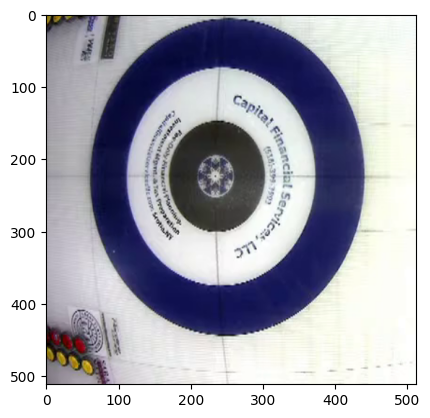

In [8]:
half = cv2.resize(sliced_img_left, (512, 512), fx = 0.1, fy = 0.1)
img = Image.fromarray(half)
plt.imshow(img)
plt.show()

We've got a solid split on this video, as I add more I'll need to manually tune the images such that the video is properly split. Combine this into a function, and we'll try to make a class as well, For now, let's hold off on the resize:

In [9]:
def crop_images(image_frame):

  cv2.cvtColor(image_frame, cv2.COLOR_BGR2RGB)
  img = Image.fromarray(frame)

  sliced_img_right = image_frame[:, image_frame.shape[0]+175:]
  sliced_img_left = image_frame[:, :image_frame.shape[0]-325]

  sliced_img_right = sliced_img_right[(image_frame.shape[1]//2)-280:, :]
  sliced_img_left = sliced_img_left[(image_frame.shape[1]//2)-280:, :]

  full_split_right, full_split_left = Image.fromarray(sliced_img_right), Image.fromarray(sliced_img_left)

  return full_split_right, full_split_left

### Bonspiel Parser Class

#### Stats to consider:
For the 2022 Achilles Bonspiel, we have ~8 hours of video feed. Assuming this video was recorded at the standard 30 frames per second, we can calculate how many frames we need to parse:

- 60 seconds * 60 minutes * 8 = 28800 seconds
- At 30 frames a second: 28800 seconds * 30 frames = 864,000 frames

So, taking caution to performance is essential, slow runtimes will not be acceptable at this scale, even with the A100 GPU.

#### Forming the Class:
Now, we can take the function above and make it into a class to attempt to parse the video feed into useable images. Two methods I'm going to try here: one is randomly generating a matrix and grabbing frames that way, though I suggest we're going to get a disproportiently large amount of blank houses. The second is to loop through the frames and try to interpret when we have a blank house vs a full house, with a higher percentage of retrieving a full house than a blank house. First, the random set:

In [ ]:
class BonspielParser():

  def __init__(self, video_path: str, frequency=.1) -> None:

    self.bonspiel_path = video_path
    self.bonspiel = None
    self.frequency = frequency

  def __mount_video(self):

    self.bonspiel = cv2.VideoCapture(self.bonspiel_path)
    return int(self.bonspiel.get(cv2.CAP_PROP_FRAME_COUNT))

  def __release_video(self):

    self.bonspiel.release()
    self.bonspiel = None

  def __crop(self, image_frame):

    cv2.cvtColor(image_frame, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(frame)

    sliced_img_right = image_frame[:, image_frame.shape[0]+175:]
    sliced_img_left = image_frame[:, :image_frame.shape[0]-325]

    sliced_img_right = sliced_img_right[(image_frame.shape[1]//2)-280:, :]
    sliced_img_left = sliced_img_left[(image_frame.shape[1]//2)-280:, :]

    full_split_right, full_split_left = Image.fromarray(sliced_img_right), Image.fromarray(sliced_img_left)

    return full_split_right, full_split_left


  def parse_frames(self):

    frame_count = self.__mount_video()
    rand_frames = np.random.randint(0, frame_count, size=(int(frame_count*self.frequency)))
    frames = set()

    for frame in rand_frames:

      self.bonspiel.set(cv2.CAP_PROP_POS_FRAMES, frame)
      success, frame_cur = self.bonspiel.read()

      if success:
        frame_cur = cv2.cvtColor(frame_cur, cv2.COLOR_BGR2RGB)
        frames.add(frame_cur)

    self.__release_video()
    return frames


if __name__ == "__main__":
  bonspiel = BonspielParser('/content/drive/My Drive/CurlingVideos/achilles2022.mp4')
  frames = bonspiel.parse_frames()





